# Consumer Financial Protection Bureau - Consumer Complaints
## Exploratory Data Analysis - Part 1

### Loading required Libraries

In [16]:
library(readr)
library(dplyr)
library(ggplot2)
library(quanteda)
library(RColorBrewer)
library(wordcloud)
library(openxlsx)
library(datasets)
library(tm)
library(scales)


Attaching package: 'scales'

The following object is masked from 'package:readr':

    col_factor



### Loading the data set

In [5]:
data <- read_csv("cc.csv", na = c("NA", "N/A", NULL, ""), progress = TRUE)
glimpse(data)

Parsed with column specification:
cols(
  complaint_id = col_integer(),
  date_received = col_datetime(format = ""),
  date_sent_to_company = col_datetime(format = ""),
  company = col_character(),
  product = col_character(),
  sub_product = col_character(),
  issue = col_character(),
  submitted_via = col_character(),
  company_public_response = col_character(),
  state = col_character(),
  zip_code = col_character(),
  company_response = col_character(),
  consumer_disputed = col_character(),
  sub_issue = col_character(),
  complaint_what_happened = col_character(),
  consumer_consent_provided = col_character(),
  timely = col_character(),
  tags = col_character()
)


|=================================================================| 100%  576 MB
Observations: 1,078,137
Variables: 18
$ complaint_id              <int> 14372, 1216062, 1357172, 1770766, 868283,...
$ date_received             <dttm> 2012-01-17, 2015-01-29, 2015-05-01, 2016...
$ date_sent_to_company      <dttm> 2012-01-20, 2015-01-29, 2015-05-01, 2016...
$ company                   <chr> "JPMORGAN CHASE & CO.", "RFNA, LP", "BANK...
$ product                   <chr> "Mortgage", "Debt collection", "Mortgage"...
$ sub_product               <chr> "Conventional fixed mortgage", "Other (i....
$ issue                     <chr> "Loan modification,collection,foreclosure...
$ submitted_via             <chr> "Phone", "Web", "Web", "Fax", "Web", "Ref...
$ company_public_response   <chr> NA, NA, NA, NA, NA, "Company chooses not ...
$ state                     <chr> "CA", "SC", "PA", "MD", "CA", "VA", "PA",...
$ zip_code                  <chr> "94404", "29657", "15063", "21239", "9211...
$ company_re

#### Data benchmarks:

##### 1. Size = 576 MB
##### 2. Rows = 1078137
##### 3. Columns = 18

### Cleaning and Munging data

We find that a lot of variables belong to class factor but are in character format and hence, we convert them into factor format.
Also, we need to find out the number of missing values in the data set. We do this with the help of sapply function which throws the number of missing values in each column of our data set

In [6]:
data.frame(Missing.Values = sapply(data, function(x) sum(is.na(x))))
data$company <- as.factor(data$company)
data$product <- as.factor(data$product)
data$sub_product <- as.factor(data$sub_product)
data$issue <- as.factor(data$issue)
data$company_public_response <- as.factor(data$company_public_response)
data$state <- as.factor(data$state)
data$company_response <- as.factor(data$company_response)
data$consumer_disputed <- as.factor(data$consumer_disputed)

,Missing.Values
complaint_id,0
date_received,0
date_sent_to_company,0
company,0
product,0
sub_product,235170
issue,0
submitted_via,0
company_public_response,733283
state,13645


### Sentiment Analysis of Customer Complaints

The column **complaint_what_happened** states the complaint description that was provided by the consumer. This can give us interesting insights about the words consumers used for their description.

Hence, I was inspired to perform sentiment analysis on the complaint description provided by the consumer finding out what where the consumers saying in their complaints!

Here, we find that approximately 640K complaint description have missing values. We remove them and treat the rest as a large Corpus.

I started the text cleaning process following these steps:- 
    
    1. Remove missing values
    2. Substitute unnecessary words with empty character string
    3. Removed punctuations
    4. Removed Numbers
    5. Converted the text to lower space
    6. Removed stopwords
    7. Striped white space

In [7]:
complaints <- data$complaint_what_happened
complaints <- complaints[!is.na(complaints)]
complaints <- gsub("XXXX", "", complaints)
complaints <- gsub("XX", "", complaints)
sample_corpa <- Corpus(VectorSource(complaints))
sample_corpa <- tm_map(sample_corpa, content_transformer(removePunctuation))
sample_corpa <- tm_map(sample_corpa, content_transformer(removeNumbers))
sample_corpa <- tm_map(sample_corpa, content_transformer(function(x){tolower(x)}))
sample_corpa <- tm_map(sample_corpa, removeWords, c('xxxx', c(stopwords('en'))))
sample_corpa <- tm_map(sample_corpa, stripWhitespace)

ERROR: Error in Corpus(VectorSource(complaints)): could not find function "Corpus"


In [10]:
png("wordcloud3.png", width = 1080, height = 720, units = 'px')
wordcloud(sample_corpa, scale=c(8,.2),min.freq=10,
          max.words=500, random.order=FALSE, rot.per=.30, colors=brewer.pal(8, "Set1"))
dev.off()

png 
  2

<img src="wordcloud3.png">

With the help of a **wordcloud**, we were able to find out the most used words and these helped us understand what people were talking about and mentioning in their complaints.

Insighting words such as:
    1. credit
    2. account
    3. payment
    4. mortgage
    5. loan
    6. money

where eye-balled which made me converge a very interesting story.

**What if the complaints registred by the consumers where related to their monetary status?** In other words, is there a scenario where, the consumer's state's median income is an indicator of the fact that he/she is more liekly to complain about **Mortgage or Credit service**

To check if this is true or not,
    1. Summarized the number of Total complaints regarding Mortgage or Credit card services that
    where received in states of USA
    2. Downloaded data regarding the median income of the states in USA
    

#### Distribution of Complaints according to States

In [18]:
ind <- c("Mortgage", "Credit card")
top_s <- data
top_s$Year <- lubridate::year(data$date_received)
top_s <- top_s %>% filter(product %in% ind & Year == 2016) %>% group_by(state) %>%
summarise(Total_Complaints = n())
top_s <- top_s %>% filter(state %in% state.abb)
top10_s <- top_s %>% top_n(10) %>% arrange(desc(Total_Complaints))
head(top_s)

Selecting by Total_Complaints


state,Total_Complaints
AK,81
AL,510
AR,237
AZ,1455
CA,9869
CO,1176


#### Median Income of states

In [19]:
median_income <- read.csv("Data USA - Geo Map of Income by Location in the United States.csv")
median_income <- median_income %>% filter(median_income$geo_name %in% state.name)
median_income$state <- rep(state.abb, 4)
median_income <- median_income %>% filter(year == 2016)
top_s <- top_s[order(factor(top_s$state,levels = state.abb)), ]
head(median_income)

year,geo_name,geo,income,state
2016,Alabama,04000US01,44758,AL
2016,Alaska,04000US02,74444,AK
2016,Arizona,04000US04,51340,AZ
2016,Arkansas,04000US05,42336,AR
2016,California,04000US06,63783,CA
2016,Colorado,04000US08,62520,CO


In [20]:
head(median_income_c)

year,geo_name,geo,income,state,Complaints,Quantile
2016,Maryland,04000US24,76067,MD,2051,Forth 25%
2016,Alaska,04000US02,74444,AK,81,Forth 25%
2016,New Jersey,04000US34,73702,NJ,3064,Forth 25%
2016,Hawaii,04000US15,71977,HI,223,Forth 25%
2016,Connecticut,04000US09,71755,CT,798,Forth 25%
2016,Massachusetts,04000US25,70954,MA,1413,Forth 25%


In [21]:
median_income_c <- median_income
median_income_c$Complaints <- top_s$Total_Complaints
median_income_c$Quantile <- with(median_income_c, cut(income, 
                                breaks=quantile(income, probs=seq(0,1, by=0.25), na.rm=TRUE), 
                                include.lowest=TRUE, labels=c("Bottom 25%","Second 25%",
                                                              "Third 25%","Forth 25%")))
median_income_c <- median_income_c %>% arrange(desc(income))
quantile_comp <- median_income_c %>% group_by(Quantile) %>% summarise(Total_Complaints = sum(Complaints)) %>%
mutate(Proportion = paste0(round(Total_Complaints / sum(Total_Complaints) * 100), "%"))
head(quantile_comp)

Quantile,Total_Complaints,Proportion
Bottom 25%,11782,19%
Second 25%,10865,18%
Third 25%,15177,25%
Forth 25%,23643,38%


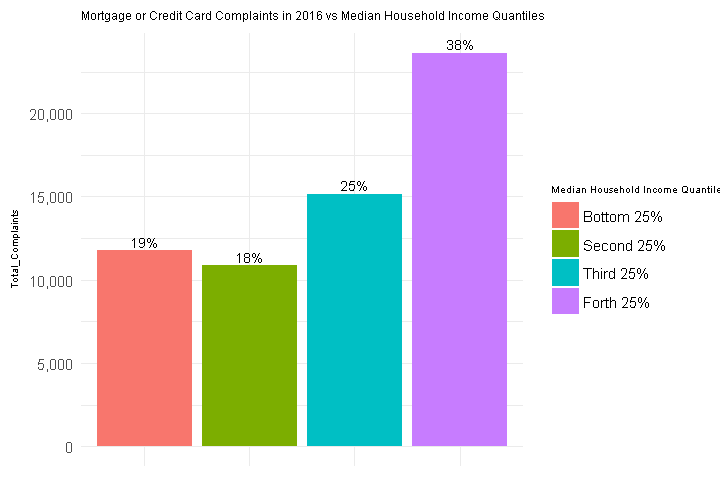

In [22]:
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(quantile_comp, aes(Quantile, Total_Complaints, fill = as.factor(Quantile))) +
  geom_bar(stat = 'identity') + scale_y_continuous(labels = comma) +
  geom_text(aes(label = Proportion), size=3, position = position_dodge(0.9), vjust = -0.3) +
  labs(fill = 'Median Household Income Quantile') + scale_x_discrete("Quartile", labels = NULL) + 
  ggtitle("Mortgage or Credit Card Complaints in 2016 vs Median Household Income Quantiles") +
  theme_minimal() + 
  theme(axis.title.x = element_blank(), title = element_text(size = 6))

### Conclusions

    1. Analyzing the complaint description provided by the consumer, we found interesting words
    related to Consumer's Financial scenario
    
    2. Most Frequent appearing words were
        1. Credit
        2. Account
        3. Payment
    
    3. The rich states complain twice as much as the bottom quantile states about the Mortgage and
    Credit Card services which make nearly 45% of the total complaints
    
    4. The analysis reveals evidence that the well - off, rich states in USA are more likely to submit
    complain to CFPB. These type of consumers likely have more resources available to them and hence 
    have more problems that need solutions